### Stastically motivated model
This is an idea I had for a model which is based purely on two easily observable facts

1. The BPs are clustered around -28 NTs from the acceptor site
2. The BPs are mostly As

By measuring the exact distributions of both of these we can come up with a rough probability that any given NT is a BP. We then just feed these probabilities to SKlearn with some labels to calculate the precision-recall curve and average precision.

Precision-recall curves can be used to find the decision boundary which maximizes F1 and we can calculate both F1 and PER SEQUENCE accuracy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

### Load data and split it into train and test (has to be split the same way as for ML tests)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/Machine_Learning_(CS-433)/Project_2"

/content/drive/MyDrive/Machine_Learning_(CS-433)/Project_2


In [4]:
#Assume a folder named dataset exists in the same directory as the code repository
data_path = 'data'

#assume dataset itself is just named dataset.txt
df = pd.read_csv(os.path.join(data_path, "dataset.txt"), delimiter = "\t")

df['BP_POS_WITHIN_STRAND'] = df['IVS_SIZE'] + df['BP_ACC_DIST']

In [10]:
#Import useful functions from repository
!pip install datasets
from BP_LM.scripts.data_preprocessing import split_train_test_on_chr,  extract_intron_seq_and_labels, truncate_strands

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [11]:
df.columns.values

array(['CHR', 'START', 'END', 'STRAND', 'GENE', 'TRANSCRIPT', 'IVS',
       'IVS_SIZE', 'BP_POS', 'BP_ACC_DIST', 'BP_ACC_SEQ', 'IVS_SEQ',
       'BP_POS_WITHIN_STRAND'], dtype=object)

In [13]:
#Create a split based on chromosome types (Alis idea)
#We do this split to keep our tests fair to the machine learning models.
train_df, test_df, val_df = split_train_test_on_chr(df, shuffle=True)

Chromosomes in train set: {'chr12', 'chr19', 'chr1', 'chr5', 'chr4', 'chr2', 'chr3', 'chr16', 'chr18', 'chr14', 'chr22', 'chr13', 'chr20', 'chr17', 'chr15', 'chrY', 'chr21', 'chr6', 'chr7', 'chrX'}
Chromosomes in validation set: {'chr10', 'chr9'}
Chromosomes in test set: {'chr8', 'chr11'}

Total data points: 177980
Train set contains 147559 data points (82.91%)
Validation set contains 14434 data points (8.11%)
Test set contains 15987 data points (8.98%)


### Compute distributions regarding the BPs

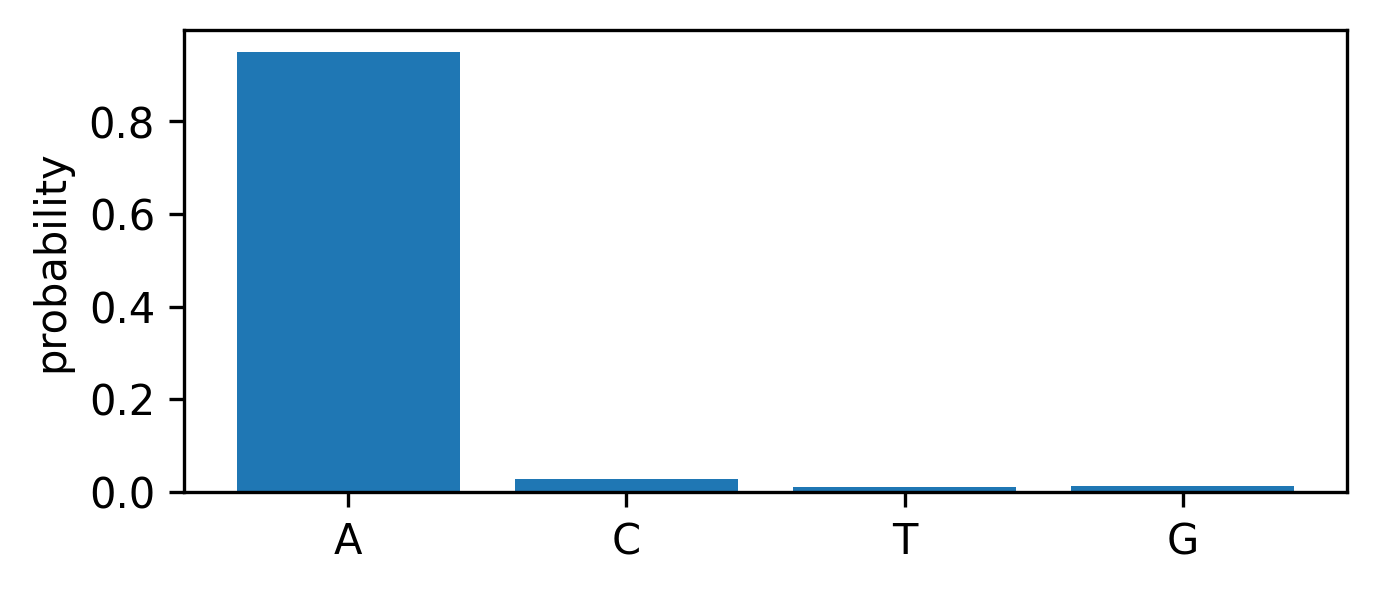

In [14]:
#find probability of a BP being a given nucleotide
base_counts = {"A": 0, "C": 0, "T": 0, "G": 0}

for i, sequence in enumerate(train_df["IVS_SEQ"]):
    base = sequence[train_df["BP_ACC_DIST"][i]]
    if base in base_counts:
        base_counts[base] += 1

As, Cs, Ts, Gs = base_counts["A"], base_counts["C"], base_counts["T"], base_counts["G"]

As /= len(train_df["IVS_SEQ"])
Cs /= len(train_df["IVS_SEQ"])
Ts /= len(train_df["IVS_SEQ"])
Gs /= len(train_df["IVS_SEQ"])

NT_probs = {"A": As, "C" : Cs, "T" : Ts, "G" : Gs}

#Plot probability of NTs
fig, ax = plt.subplots(figsize = (5,2), dpi = 300)
ax.bar(["A", "C", "T", "G"], [As, Cs, Ts, Gs])
ax.set_ylabel('probability')
fig.savefig("NT_hist.png")
plt.show()

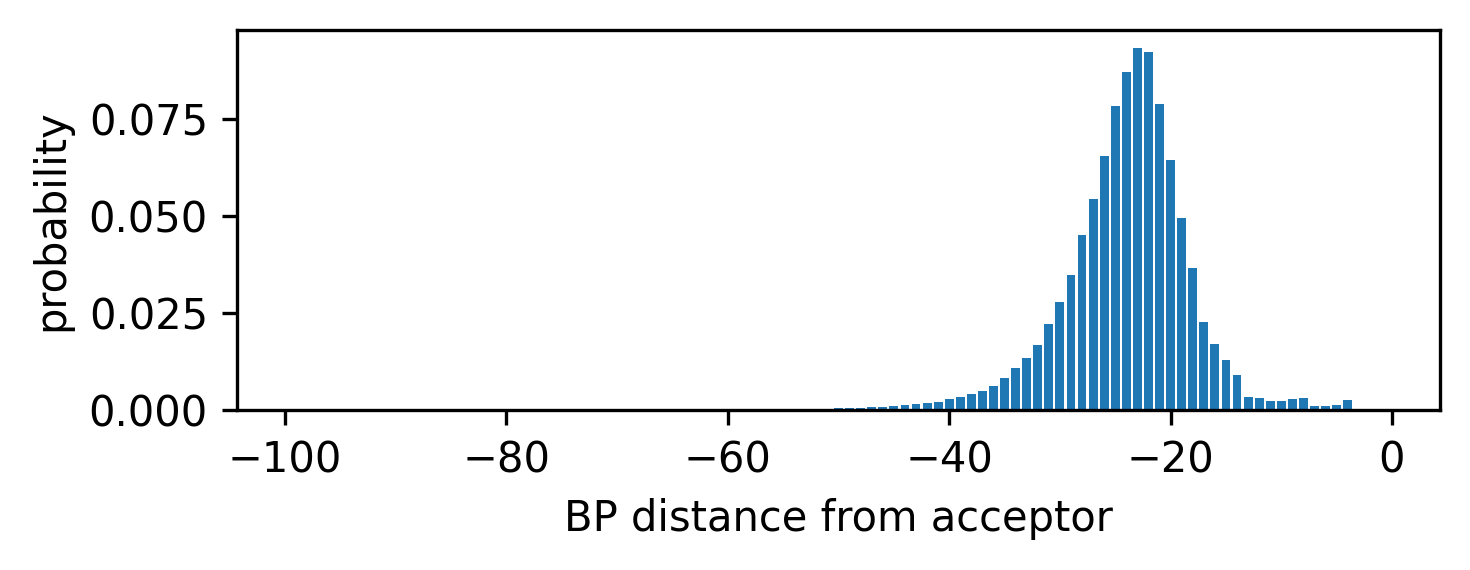

In [15]:
positions = df["BP_ACC_DIST"].to_numpy()

minimum = np.min(positions)
maximum = np.max(positions)
avg = np.mean(positions)

fig, ax = plt.subplots(figsize = (5,2), dpi = 300, tight_layout=True)
#n, bins, patches = ax.hist(positions, 0-minimum, (minimum,0))
bins = np.arange(minimum, 1, 1)
n, _ = np.histogram(positions, bins)
probs = n/np.sum(n) # Turn into probability distribution
ax.bar(bins[:-1], probs)
ax.set_xlabel("BP distance from acceptor")
ax.set_ylabel("probability")
fig.savefig("place_hist.png")
fig.show()


In [16]:
location_probabilities = n/len(df["BP_ACC_DIST"]) #normalize the probabilities
positions = bins[:-1] # bin limits are exclusive on right side, so crop end.
truncation_length = np.abs(minimum) #Figure out which interval is important

### Extract sequences and data

In [17]:
#Truncate to the furthest BP seen in the training data, makes things run faster at zero cost to the model performance
test_seqs, test_labels = extract_intron_seq_and_labels(test_df, max_model_input_size=truncation_length, truncate=True)
val_seqs, val_labels = extract_intron_seq_and_labels(test_df, max_model_input_size=truncation_length, truncate=True)

### Now we define the "model" which will calculate branch point probabilities

In [18]:
#This "model" is quite a lot simpler than the ML approaches
def probability_calculator(seqs, loc_probs, NT_probs):
  """
  input : seqs
    List of DNA strings with the acceptor at the right

  output : probabilities
    List of lists which each have length len(seq) containing probabilities
  """
  probabilities = []
  for seq in seqs:
    loc_probs_copy = loc_probs.copy() # This is necessary to avoid shallow copies overwriting loc_probs globally
    probability = loc_probs_copy[-len(seq):] #Truncate to the right length
    for i, base in enumerate(seq):
      probability[i] *= NT_probs[base] # Account for NT probabilities
    probabilities.append(probability)
  return probabilities

### Apply the model

In [19]:
#Get all the predicted probabilities
probabilities = probability_calculator(val_seqs, location_probabilities, NT_probs)

### Get AP, ideal threshold and F1

In [20]:
#First get AP metrics
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay, precision_recall_curve
def calc_AP(probabilities, labels):

  long_prob = []
  for prob_list in probabilities:
    long_prob += prob_list.tolist()

  long_labels = []
  for label_list in labels:
    long_labels += label_list

  AP = average_precision_score(long_labels, long_prob)
  precision, recall, thresholds = precision_recall_curve(long_labels, long_prob)
  return AP, precision, recall, thresholds

In [21]:
AP, precision, recall, thresholds = calc_AP(probabilities, test_labels)
F1 = np.max(2 * (precision * recall) / (precision + recall))

In [22]:
# Find ideal decision boundary for maximum F1
ideal_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall))]
ideal_recall = recall[np.argmax(2 * (precision * recall) / (precision + recall))]

### Calculate accuracy per sequence at ideal decision boundary and check if all predicted BPs are As

In [23]:
def accuracy_calculator(probabilities, labels, threshold, seqs = None):
  N_correct = 0
  all_As = True

  #Find predictions given threshold
  for i, prob_list in enumerate(probabilities):
    prediction = np.where(prob_list > threshold, 1, 0)

    if seqs != None: #If seqs have been passed this checks if all BPs are As
      for index in (np.where(prediction == 1)[0]):
        if seqs[i][index] != "A":
          all_As = False

    #Check if sequence label is entirely correct
    if np.array_equal(prediction, labels[i]):
      N_correct += 1

  if seqs != None:
    print("Are all predicted BPs As? {}".format(all_As))

  return N_correct/len(probabilities)

In [24]:
accuracy = accuracy_calculator(probabilities, test_labels, ideal_threshold, test_seqs)

Are all predicted BPs As? True


### Evaluation Results

In [25]:
eval_benchmarks = {"accuracy" : accuracy, "AP" : AP, "F1" : F1}

In [26]:
print(eval_benchmarks)

{'accuracy': 0.17652764306498545, 'AP': 0.3079060221645208, 'F1': 0.42026581847097577}


### Test results
We need to reuse the decision boundary from the evaluation optimization to get some results on the test set

In [27]:
test_probs = probability_calculator(test_seqs, location_probabilities, NT_probs)

In [35]:
#Adding some extra metrics to the AP function
from sklearn.metrics import matthews_corrcoef, roc_auc_score, f1_score, log_loss

def sigmoid(x):
  return 1/(1+np.exp(-x))

def calc_figures_of_merit(probabilities, labels, decision_boundary):

  long_prob = []
  for prob_list in probabilities:
    long_prob += prob_list.tolist()

  long_labels = []
  for label_list in labels:
    long_labels += label_list

  #Normalize the probabilities (necessary for cross entropy loss)
  long_prob = sigmoid(np.array(long_prob))
  loss = log_loss(long_labels, long_prob)

  #We don't need the thresholds in this case
  AP = average_precision_score(long_labels, long_prob)
  precision, recall, _ = precision_recall_curve(long_labels, long_prob)

  #Calc a variety of figures of merit using pre chosen decision boundary
  cat_preds = np.where(long_prob > decision_boundary, 1, 0)
  MCC = matthews_corrcoef(long_labels, cat_preds)
  ROC = roc_auc_score(long_labels, long_prob)
  F1 = f1_score(long_labels, cat_preds)

  return AP, MCC, ROC, F1, loss, precision, recall

In [36]:
AP, MCC, ROC, F1, loss, precision, recall = calc_figures_of_merit(test_probs, test_labels, ideal_threshold)
accuracy = accuracy_calculator(test_probs, test_labels, ideal_threshold, test_seqs)

Are all predicted BPs As? True


In [37]:
#Save AP curve
np.savetxt("pr_curve_naive.txt", np.vstack((precision,recall)).T)

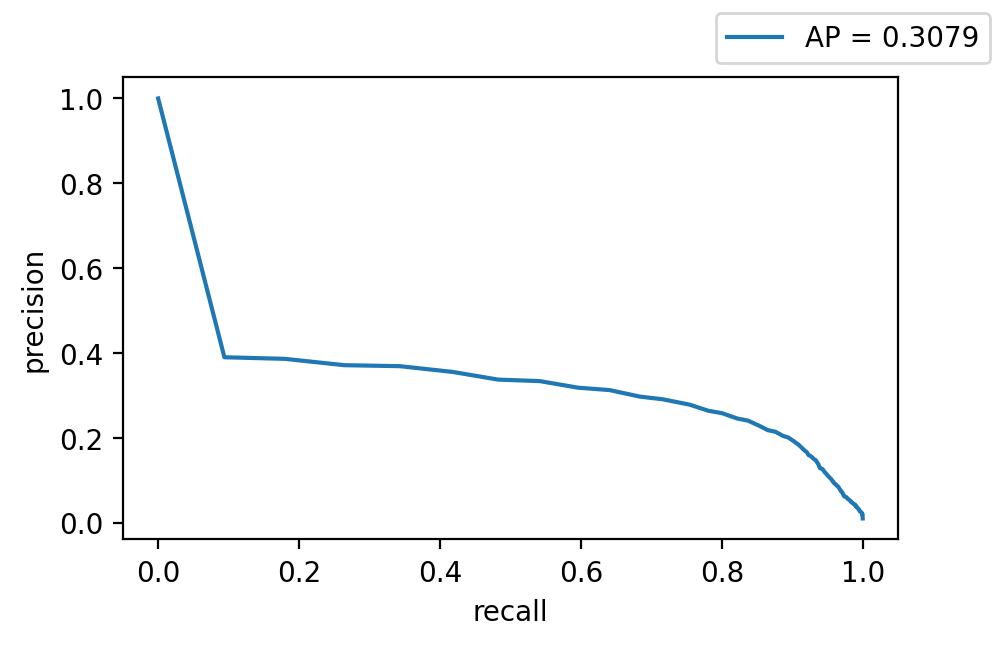

In [38]:
#Plot precision recall curve
fig, ax = plt.subplots(figsize = (5,3), dpi = 200)
ax.plot(recall, precision, label = "AP = {0:.4f}".format(AP))
ax.set_ylabel("precision")
ax.set_xlabel("recall")
fig.legend()

In [39]:
test_benchmarks = {"accuracy" : accuracy, "loss" : loss, "AP" : AP, "F1" : F1, "MCC" : MCC, "ROC" : ROC}

In [40]:
print(test_benchmarks)

{'accuracy': 0.17652764306498545, 'loss': 0.6937504363522846, 'AP': 0.3079060221645208, 'F1': 0.020090416617950815, 'MCC': 0.0, 'ROC': 0.9785456129720155}
